# **PATHS**

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
# Path to the dataset
dataset_path = '/Users/admin/Downloads/building_dataset'
#dataset_path = 'Downloads/aerial imagery 2.v3i.coco'
os.chdir(dataset_path)

In [ ]:
# Directory paths to store masks
train_mask_dir = '/content/drive/My Drive/BuildingDetection/aerial imagery 2.v3i.coco/train_mask_dir'
#output_dir = 'Downloads/aerial imagery 2.v3i.coco/output'
valid_mask_dir = '/content/drive/My Drive/BuildingDetection/aerial imagery 2.v3i.coco/valid_mask_dir'
#test_mask_dir = 'Downloads/aerial imagery 2.v3i.coco/test_mask_dir'

In [ ]:
train_folder = os.path.join(dataset_path, 'train')
valid_folder = os.path.join(dataset_path, 'valid')

# **IMPORT LIBRARIES**

In [ ]:
import json
from PIL import Image
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import numpy as np
import cv2

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# **CONVERT ANNOTATIONS TO MASKS**

In [ ]:
# Load train annotations
with open(os.path.join(train_folder, '/Users/admin/Downloads/geojson')) as f:
    train_annotations = json.load(f)

In [ ]:
# Load test annotations
with open(os.path.join(valid_folder, 'annotations.coco.json')) as f:
    test_annotations = json.load(f)

In [ ]:
def create_segmentation_mask(image_size, annotations, category_id=None):
    mask = np.zeros(image_size, dtype=np.uint8)
    for annotation in annotations:
        if category_id and annotation['category_id'] != category_id:
            continue
        # Check if the segmentation data exists and is non-empty
        if len(annotation['segmentation']) == 0:
            continue
        polygon = annotation['segmentation'][0]  # The first set of points in segmentation
        polygon = np.array(polygon).reshape((-1, 2))
        cv2.fillPoly(mask, [polygon.astype(np.int32)], 1)
    return mask

def save_mask(mask, output_path):
    Image.fromarray(mask * 255).save(output_path)

In [ ]:
def generate_masks(coco_data, output_dir):
    images_info = {img['id']: img for img in coco_data['images']}
    for annotation in coco_data['annotations']:
        image_info = images_info[annotation['image_id']]
        image_size = (image_info['height'], image_info['width'])

        # Get all annotations for this image
        image_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == annotation['image_id']]

        # Create mask
        mask = create_segmentation_mask(image_size, image_annotations)

        # Save the mask
        mask_name = image_info['file_name'].replace('.jpg', '_mask.png')
        save_mask(mask, os.path.join(output_dir, mask_name))

In [ ]:
generate_masks(train_annotations, train_mask_dir)
generate_masks(test_annotations, valid_mask_dir)

# **LOAD DATA**

In [ ]:
def load_data(image_dir, mask_dir):
    images = []
    masks = []

    for image_name in os.listdir(image_dir):
        try:
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Load image
                img = load_img(os.path.join(image_dir, image_name), target_size=(640, 640))
                img = img_to_array(img) / 255.0
                images.append(img)

                # Load corresponding mask
                mask_name = image_name.replace('.jpg', '_mask.png')
                mask_path = os.path.join(mask_dir, mask_name)

                if os.path.exists(mask_path):
                    mask = load_img(mask_path, color_mode="grayscale", target_size=(640, 640))
                    mask = img_to_array(mask) / 255.0
                    masks.append(mask)
                else:
                    print(f"Mask for {image_name} not found.")
            else:
                print(f"Skipped non-image file: {image_name}")

        except UnidentifiedImageError as e:
            print(f"Cannot identify image file: {image_name} - {e}")

    return np.array(images), np.array(masks)

# Load data
train_images, train_masks = load_data(train_folder, train_mask_dir)
test_images, test_masks = load_data(valid_folder, valid_mask_dir)

Skipped non-image file: annotations.coco.json
Skipped non-image file: annotations.coco.json


# **DISPLAY IMAGES**

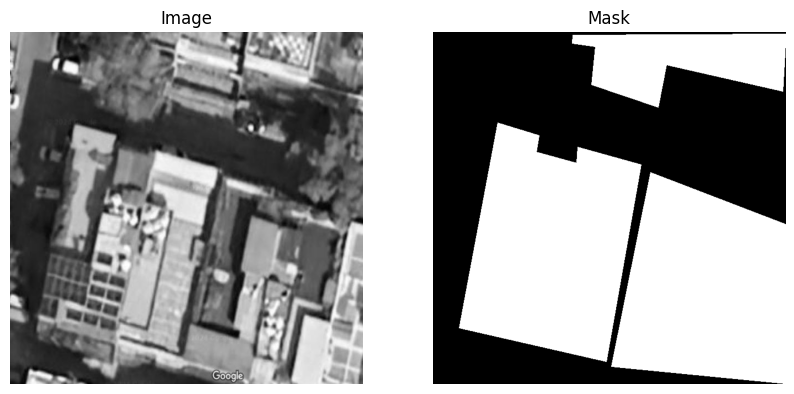

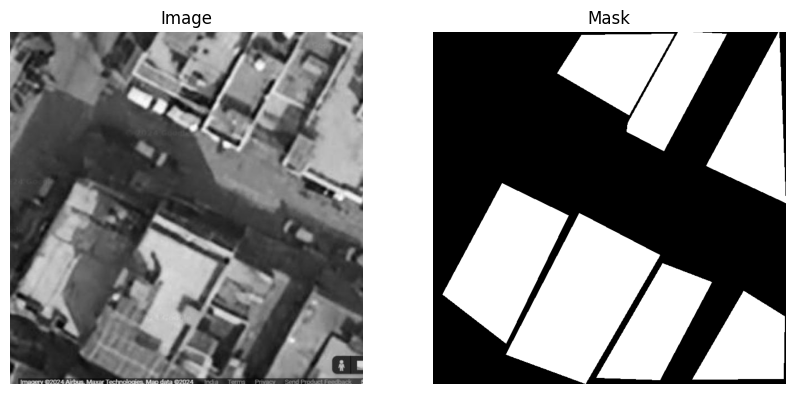

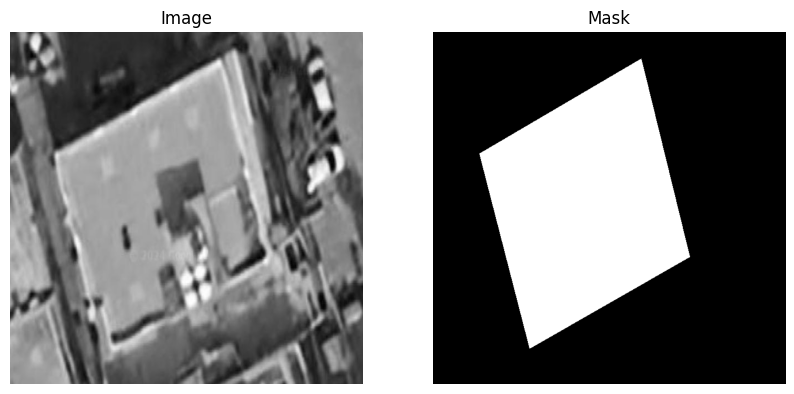

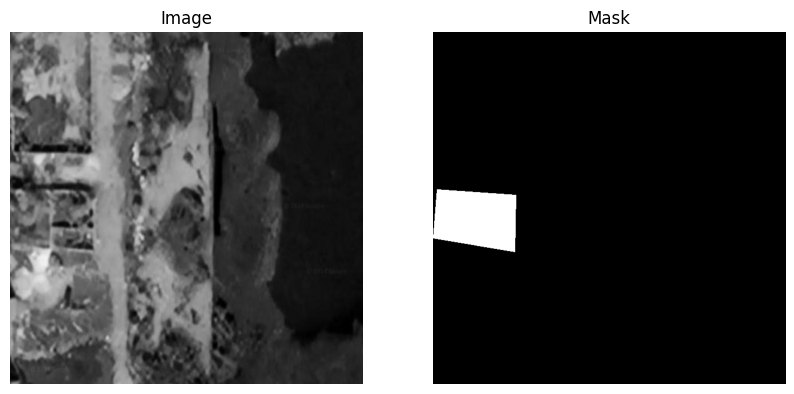

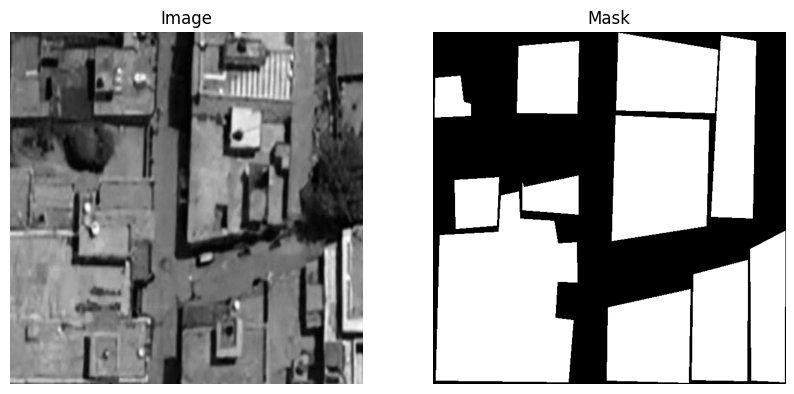

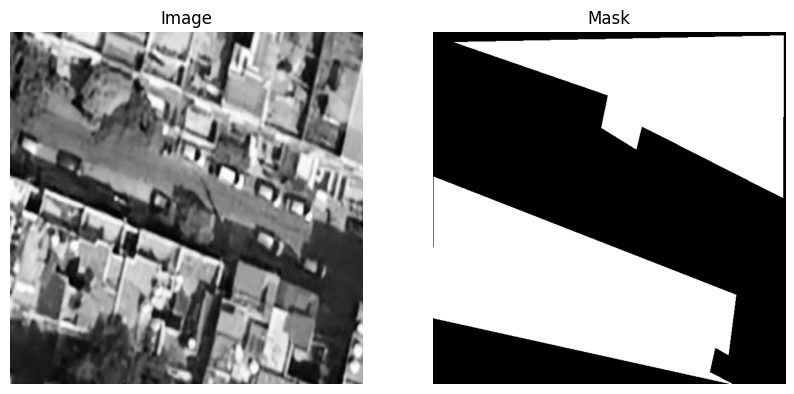

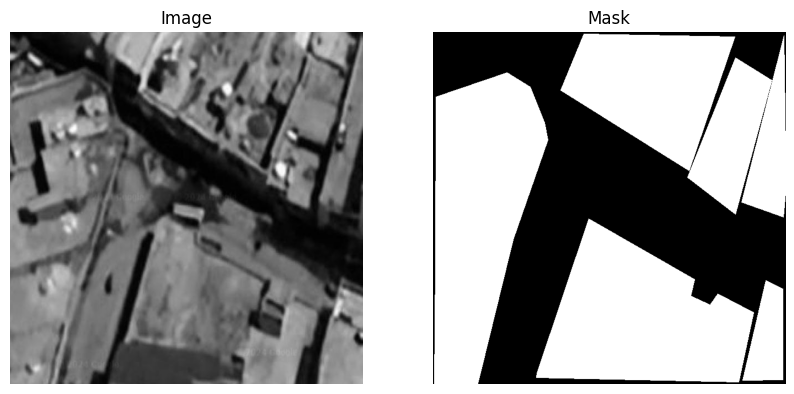

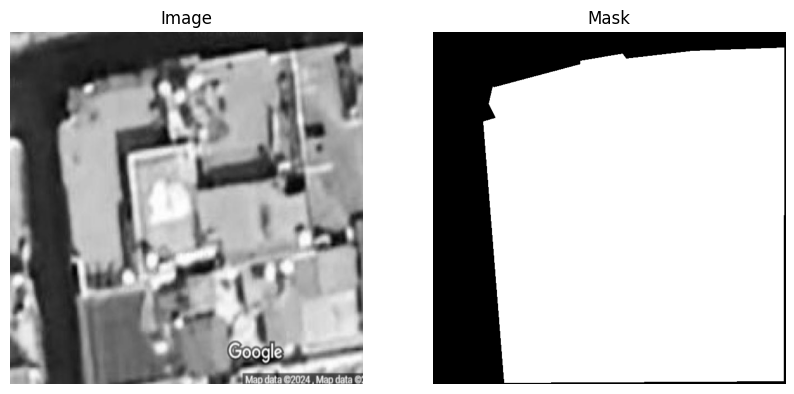

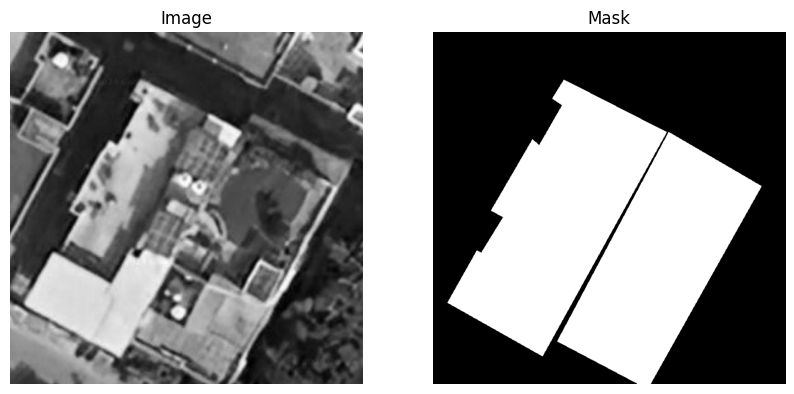

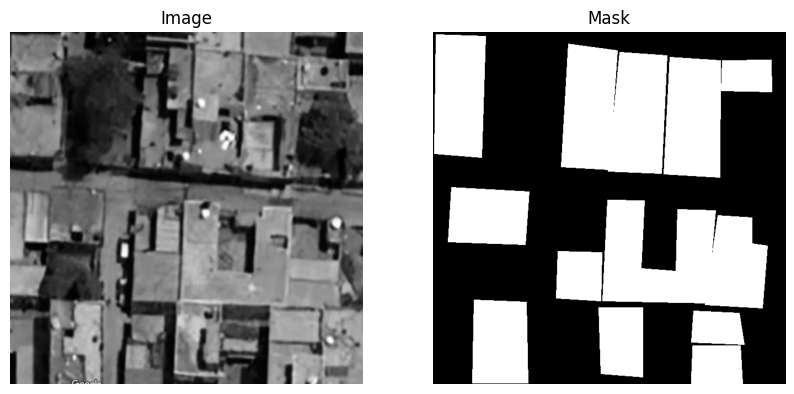

In [ ]:
def display_image_and_mask(image, mask):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display image
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis('off')

    # Display mask
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Mask")
    axs[1].axis('off')

    plt.show()

# Visualize the first few images and masks
num_images_to_visualize = 10
for i in range(min(num_images_to_visualize, len(train_images))):
    display_image_and_mask(train_images[i], train_masks[i])


# **MODEL TRAINING**

In [ ]:
checkpoint = ModelCheckpoint("best_building_detect_model.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

In [ ]:
def optimized_unet(input_shape=(640, 640, 3)):
    inputs = Input(input_shape)

    # Encoder: Contracting Path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder: Expanding Path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.2)(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.2)(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Single output channel for binary mask

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

model = optimized_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 640, 640, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 640, 640, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 640, 640, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 640, 640, 16)   │          2,320 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 640, 640, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 320, 320, 16)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 320, 320, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 320, 320, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 320, 320, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 320, 320, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 320, 320, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 160, 160, 32)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 160, 160, 32)   │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 160, 160, 64)   │         18,496 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 160, 160, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 160, 160, 64)   │         36,928 │ batch_normalization_4… │
├──────────────────────

 Total params: 1,946,993 (7.43 MB)

 Trainable params: 1,944,049 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
model.fit(train_images, train_masks, validation_data=(test_images, test_masks), epochs=25, batch_size=4, callbacks=[checkpoint, early_stopping])

Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.6764 - loss: 0.6341 - val_accuracy: 0.5250 - val_loss: 25.6079
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 247ms/step - accuracy: 0.7433 - loss: 0.5291 - val_accuracy: 0.7434 - val_loss: 1.7945
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.7599 - loss: 0.4991 - val_accuracy: 0.6788 - val_loss: 0.9349
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.7668 - loss: 0.4894 - val_accuracy: 0.7959 - val_loss: 0.6064
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.7794 - loss: 0.4716 - val_accuracy: 0.7965 - val_loss: 0.6876
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.7709 - loss: 0.4742 - val_accuracy: 0.8077 - val_loss: 0.4630
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.7964 - loss: 0.4416 - val_accuracy: 0.8108 - val_loss: 0.5011
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.8049 - loss: 0.4250 - val_accur

# **SAVE / LOAD MODEL**

In [ ]:
# Save the entire model (architecture, optimizer state, and learned weights)
model.save('/content/my_unet_model.h5')

In [ ]:
# Load the saved model
model = load_model('/content/drive/MyDrive/RIO_building_detect_model.keras')

In [ ]:
# Save the model in .keras format
model.save('building_detection.keras')

# **DISPLAY PREDICTIONS**

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


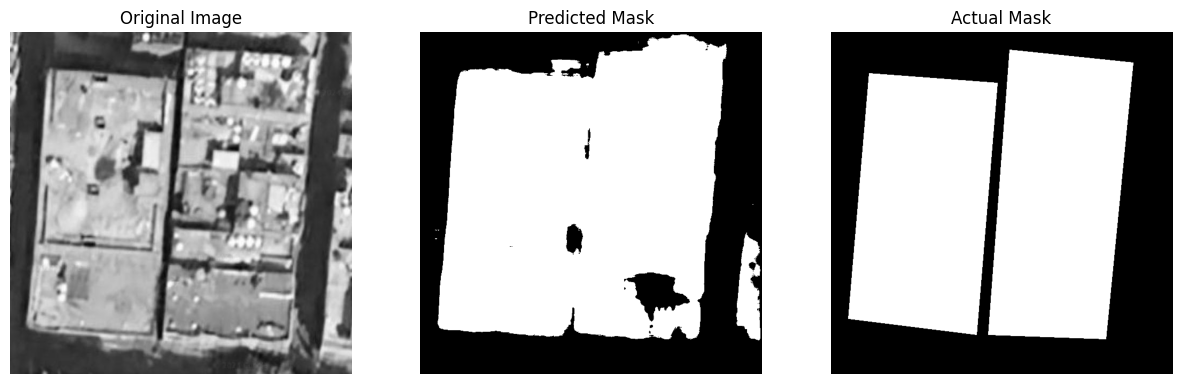

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


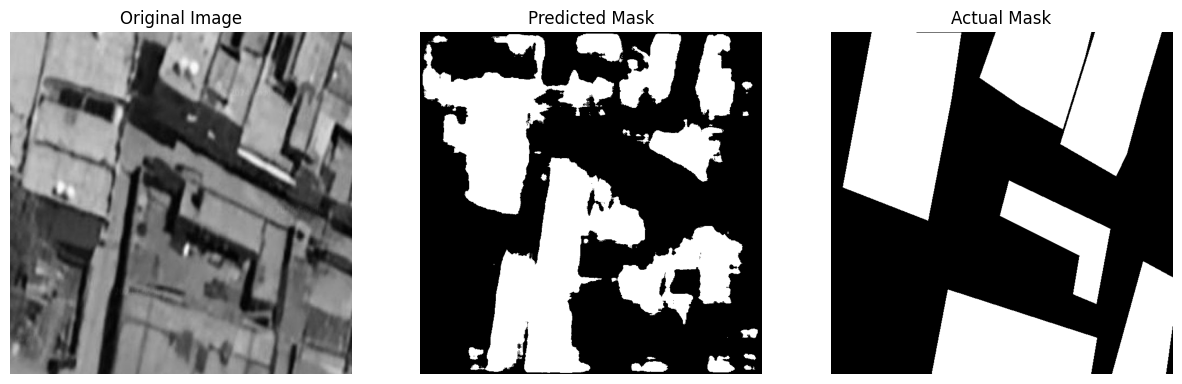

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


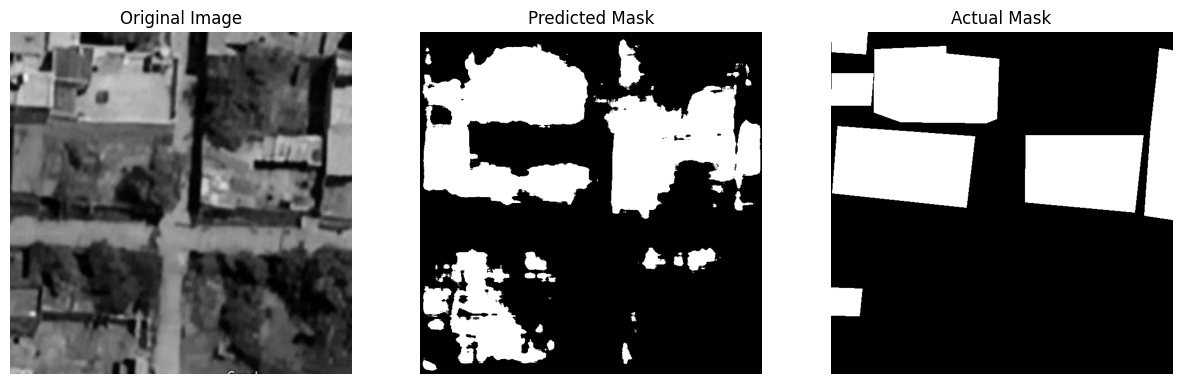

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


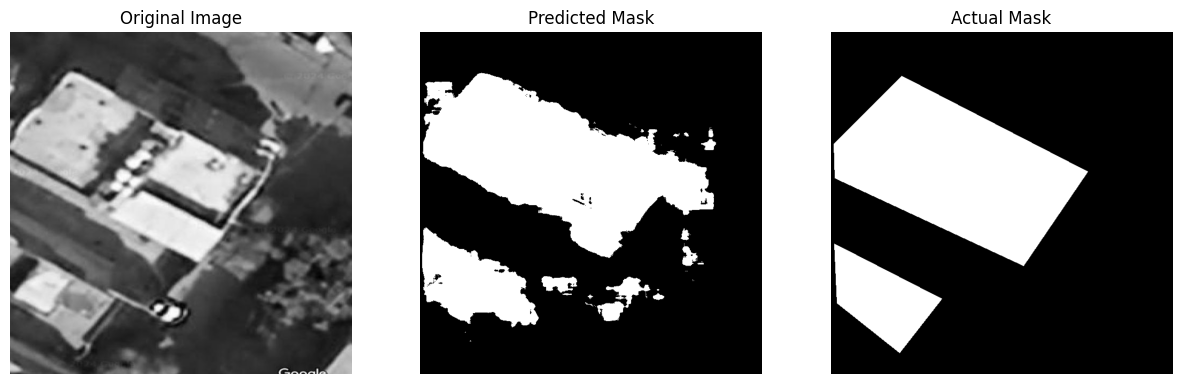

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


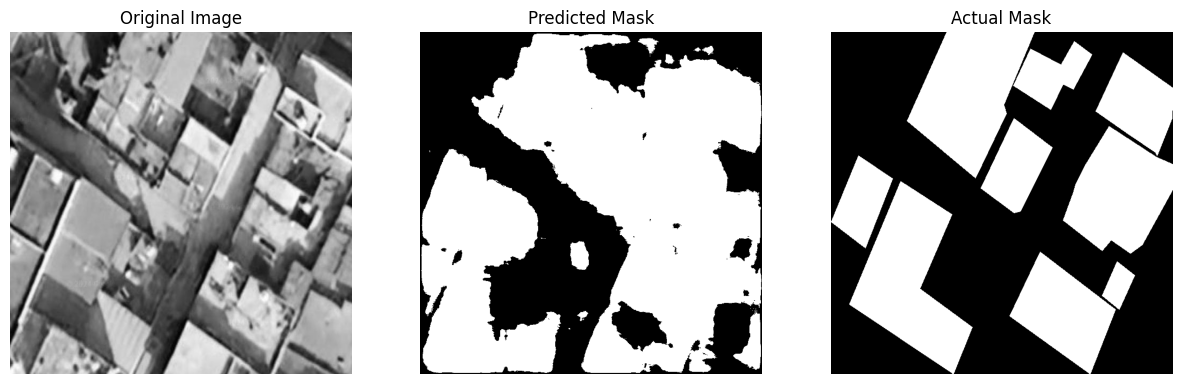

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


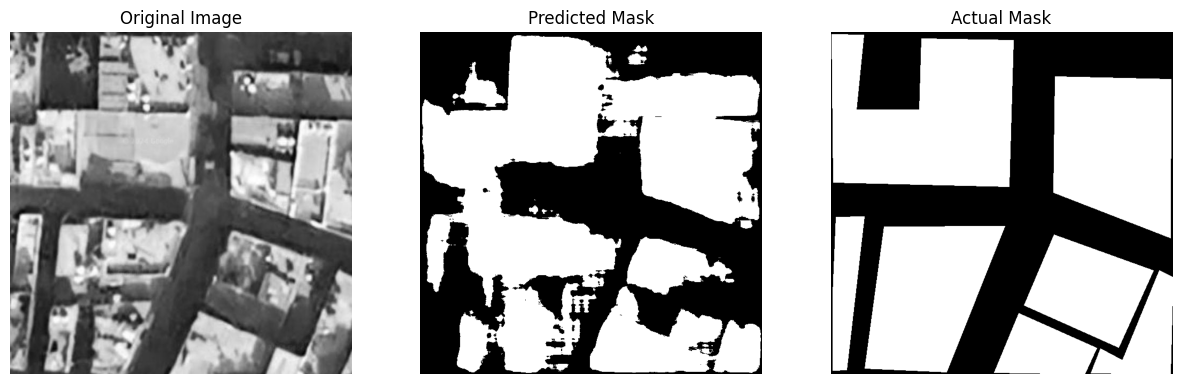

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


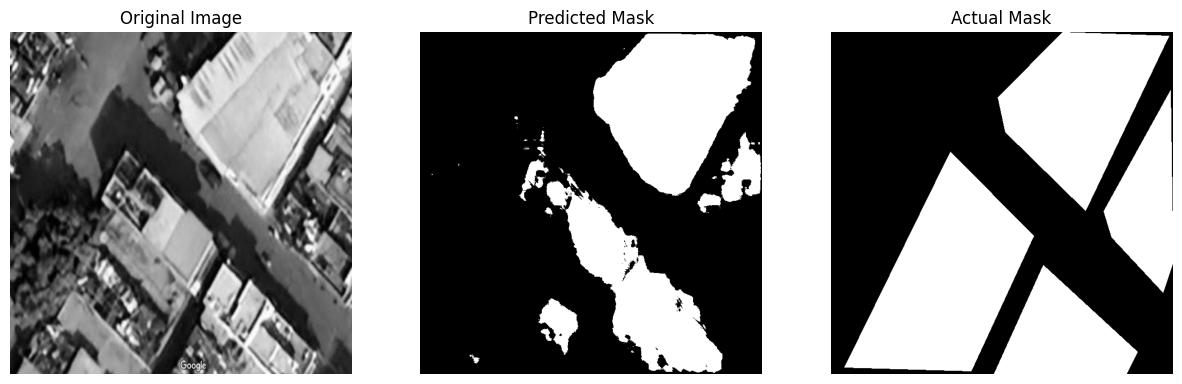

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


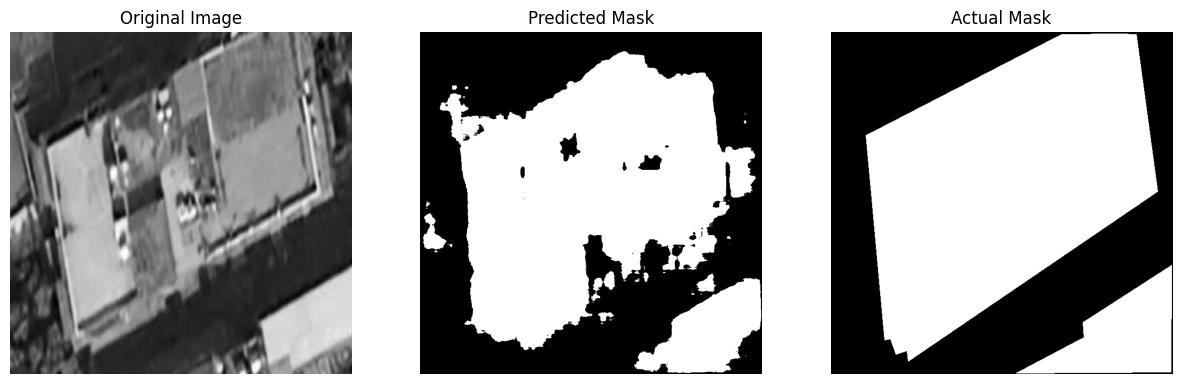

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


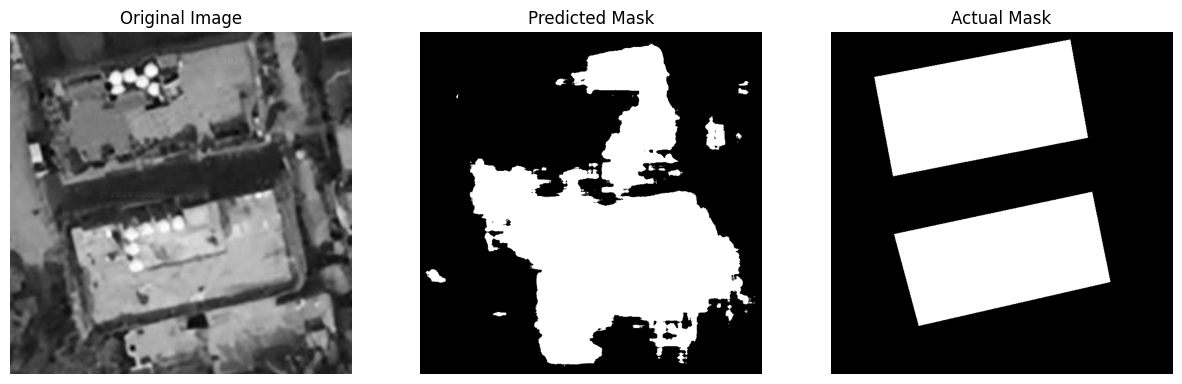

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


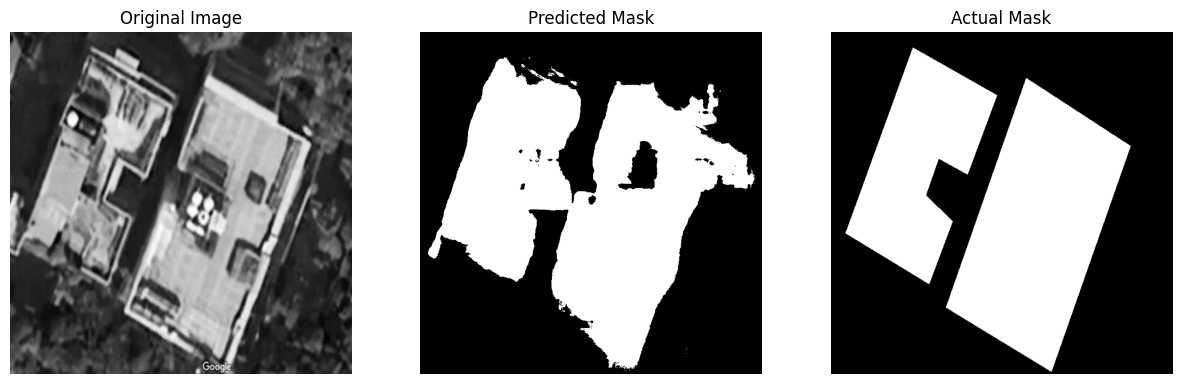

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


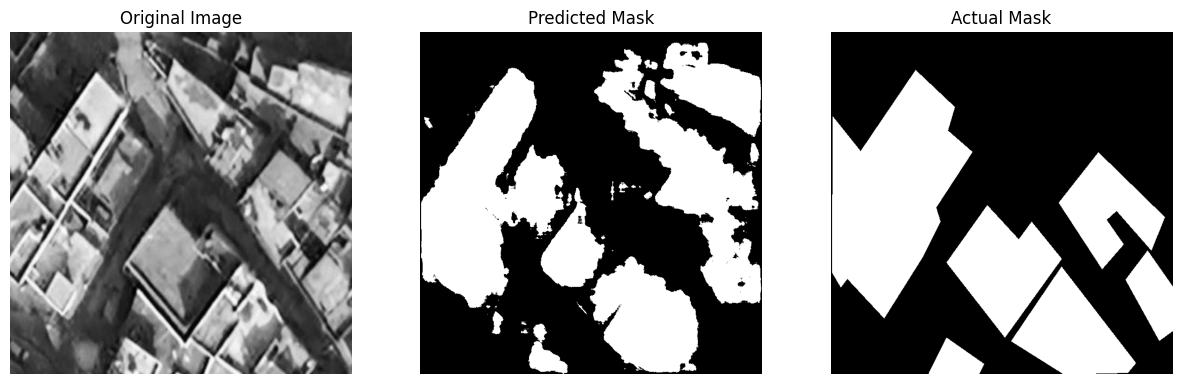

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


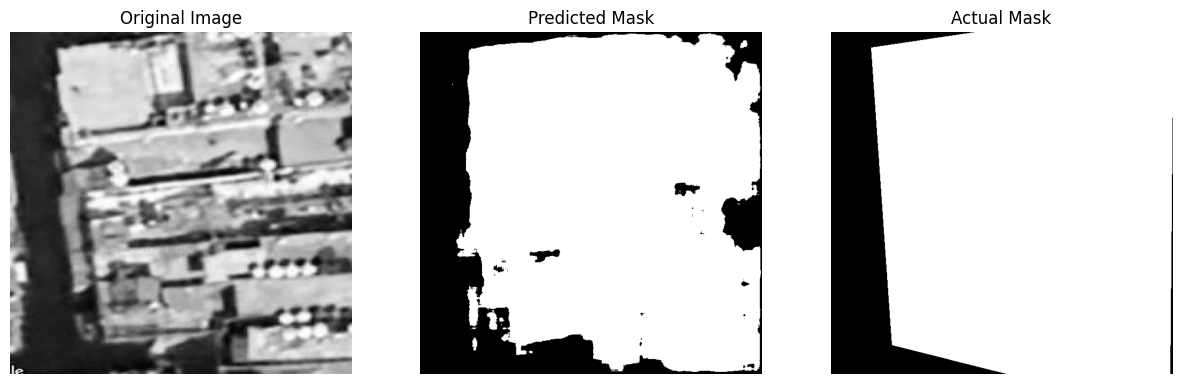

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


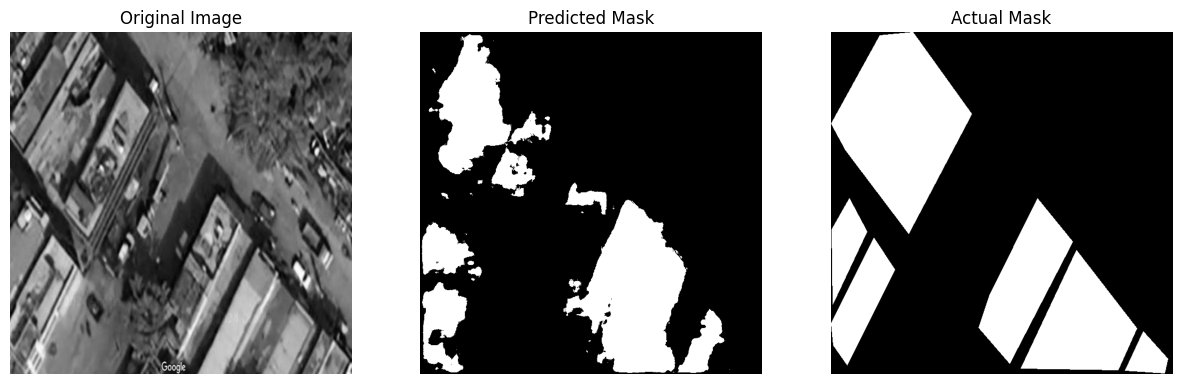

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


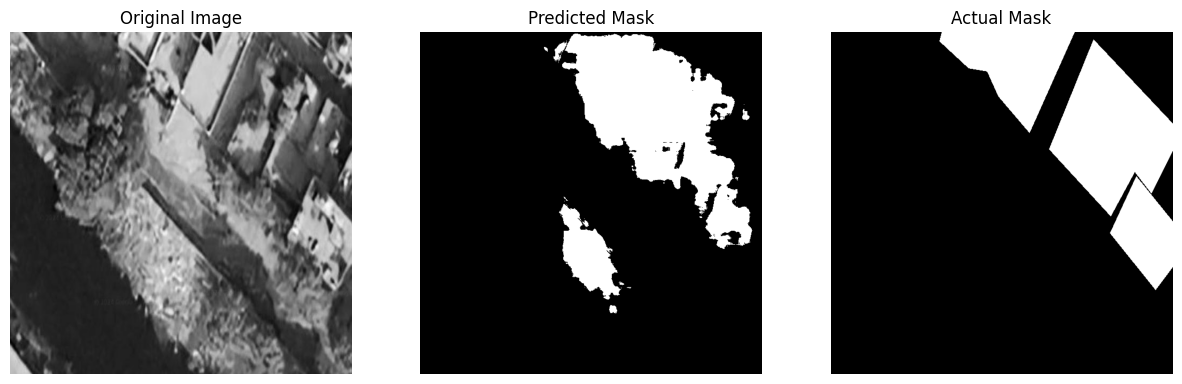

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


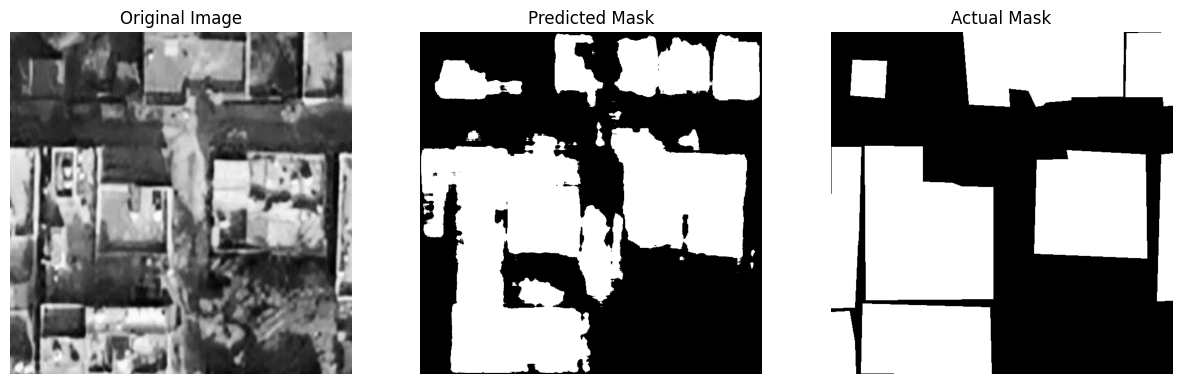

In [ ]:
def display_prediction(image, mask):
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Actual Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

# Example usage
for i in range(0,15):
    display_prediction(test_images[i], test_masks[i])


# **TEST SINGLE IMAGE**

In [ ]:
# Step 2: Load and preprocess the input image
def preprocess_image(image_path, target_size=(640, 640)):
    # Load the image
    img = load_img(image_path, target_size=target_size, color_mode="rgb")
    # Convert the image to a numpy array and normalize it (if needed)
    img_array = img_to_array(img) / 255.0
    # Add batch dimension (since the model expects input shape [batch_size, height, width, channels])
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
# Visualizing the original image and predicted mask
def visualize_prediction(image_path, predicted_mask):
    # Load the original image for comparison
    original_image = load_img(image_path, target_size=(640, 640), color_mode="rgb")
    original_image = img_to_array(original_image) / 255.0

    # Remove batch dimension from predicted_mask
    predicted_mask = predicted_mask[0, :, :, 0]

    # Plotting the original image and predicted mask side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image[:, :, 0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.show()

In [ ]:
# Load the image
image_path = '/content/very small buildings.jpg'
image = cv2.imread(image_path)

In [ ]:
input_image = preprocess_image(image_path)

In [ ]:
predicted_mask = model.predict(input_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [ ]:
print(predicted_mask.shape)
print(predicted_mask.dtype)

(1, 640, 640, 1)
float32


In [ ]:
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Binary mask thresholding

In [ ]:
predicted_mask_single = predicted_mask[0, :, :, 0]

In [ ]:
# Ensure the mask has pixel values in the range [0, 255]
predicted_mask_image = predicted_mask_single * 255  # Scale the mask values to 0-255

In [ ]:
# Check if the mask is single-channel (grayscale) and save it
if len(predicted_mask_image.shape) == 2:  # Grayscale mask
    predicted_mask_image = cv2.cvtColor(predicted_mask_image, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel BGR for display

In [ ]:
predicted_mask.shape

(1, 640, 640, 1)

In [ ]:
predicted_mask.dtype

dtype('uint8')

In [ ]:
cv2.imwrite("/content/pred_maskk.jpg", predicted_mask_image)

True

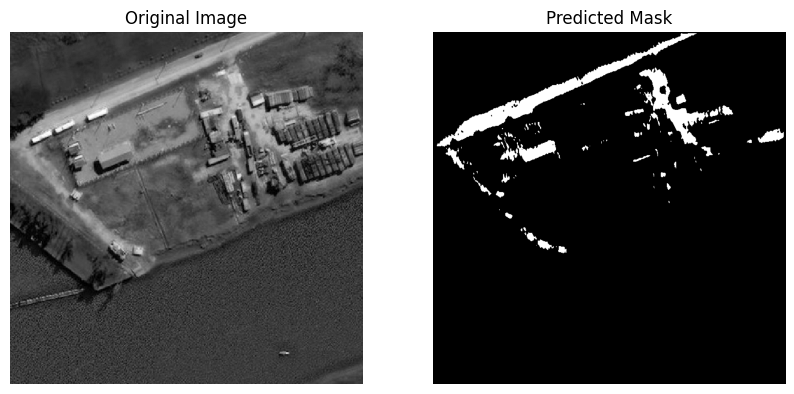

In [ ]:
visualize_prediction(image_path, predicted_mask)

# **LARGEST CONNECTED COMPONENT**

In [ ]:
# Function to retain only the largest connected component
def keep_largest_component(mask):
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Get the connected components and their labels
    num_labels, labels_im = cv2.connectedComponents(binary_mask)

    # If there is only one connected component (background not counted), return the original mask
    if num_labels <= 2:  # 1 for background and 1 for the actual component
        return mask

    # Otherwise, find the largest connected component
    largest_label = 1 + np.argmax(np.bincount(labels_im.flat)[1:])
    largest_component_mask = np.where(labels_im == largest_label, 255, 0).astype('uint8')
    return largest_component_mask

In [ ]:
# Assuming the output mask might need reshaping or post-processing to match the original image size
predicted_mask = predicted_mask.squeeze()  # Remove batch dimension if present
predicted_mask = (predicted_mask * 255).astype(np.uint8)  # Convert to uint8 type if necessary

# Process the predicted mask to keep only the largest connected component
final_mask = keep_largest_component(predicted_mask)

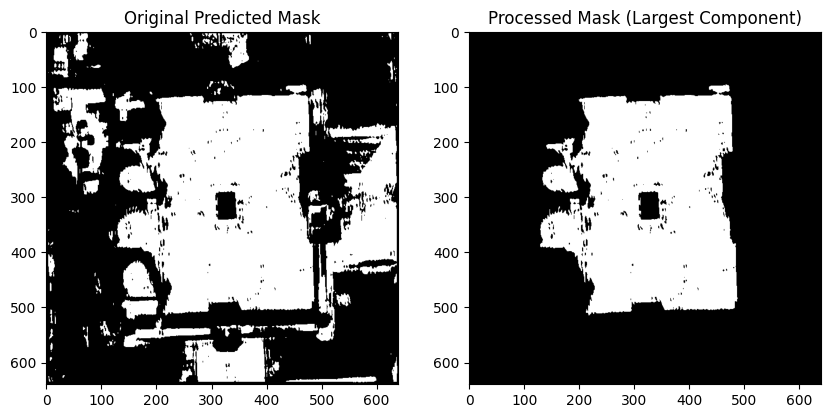

In [ ]:
# Visualization
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Original Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Processed Mask (Largest Component)")
plt.imshow(final_mask, cmap='gray')
plt.show()

In [ ]:
cv2.imwrite("/content/pred_maskk.jpg", final_mask)

True

# **POST PROCESSING**

In [ ]:
# Function to apply post-processing steps
def post_process_mask(predicted_mask):
    # Step 1: Convert the mask to a binary image (if not already done)
    # Assuming the predicted mask is still a float between 0 and 1
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Step 2: Apply morphological operations (e.g., closing to fill small gaps)
    kernel = np.ones((5, 5), np.uint8)

    # Perform closing (dilation followed by erosion) to fill small holes
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Step 3: Optionally apply Gaussian blur for smoothing
    blurred_mask = cv2.GaussianBlur(closed_mask, (5, 5), 0)

    # Step 4: Reapply thresholding after blur (if needed)
    final_mask = (blurred_mask > 0.5).astype(np.uint8)

    return final_mask

In [ ]:
# Function to display the original predicted mask and post-processed mask
def visualize_post_processing(original_mask, processed_mask):
    plt.figure(figsize=(10, 5))

    # Display original predicted mask
    plt.subplot(1, 2, 1)
    plt.title("Original Predicted Mask")
    plt.imshow(original_mask, cmap='gray')
    plt.axis('off')

    # Display post-processed mask
    plt.subplot(1, 2, 2)
    plt.title("Post-Processed Mask")
    plt.imshow(processed_mask, cmap='gray')
    plt.axis('off')

    plt.show()

In [ ]:
# Assuming the predicted_mask has already been obtained from the model and reshaped appropriately
predicted_mask_single = predicted_mask[0, :, :, 0]  # Take first mask and reshape

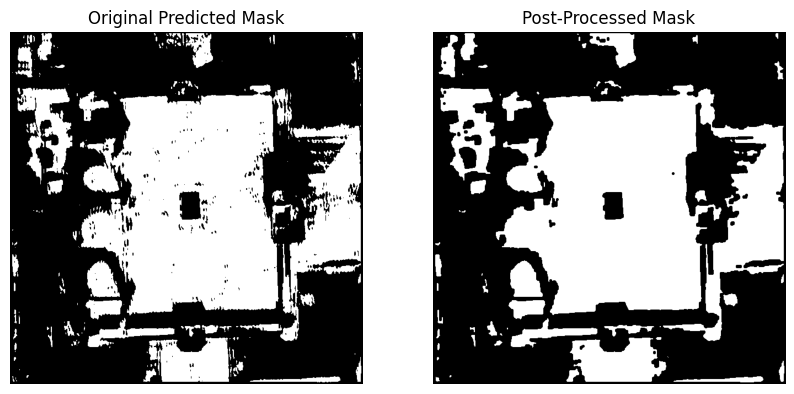

In [ ]:
# Apply post-processing steps
post_processed_mask = post_process_mask(predicted_mask_single)

# Visualize the result
visualize_post_processing(predicted_mask_single, post_processed_mask)

In [ ]:
post_processed_mask.dtype

dtype('uint8')

In [ ]:
post_processed_mask.shape

(640, 640)

In [ ]:
post_processed_mask = (post_processed_mask > 0.5).astype(np.uint8)  # Binary mask thresholding

In [ ]:
cv2.imwrite("/content/postproc_maskk.jpg", post_processed_mask)

True